## Importing Packages

In [1]:
import pandas as pd
from IPython.display import display
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.neural_network import MLPClassifier
from sklearn.exceptions import ConvergenceWarning
from sklearn import tree

from xgboost import XGBClassifier, plot_importance

# To ignore warnings in the notebook
import warnings
warnings.filterwarnings("ignore")


## Importing Dataset

In [2]:
df = pd.read_csv('XWines_Full_100K_wines.csv')

## Data Cleaning

### Grapes

In [3]:
# creating a function to remove square brackets and quotation marks
# to be used on Grapes, Harmonize and Vintages
# inputs: data is the dataframe, column_names is the name of the column (string) or list
def clean_column(data, column_names):
    
    for column_name in column_names:

        if column_name in ['Grapes', 'Harmonize']:
            # extracting all words inside 
            data[column_name] = data[column_name].apply(lambda x: re.findall(r"'(.*?)'", x))

            # convert the list of words back to a string
            data[column_name] = data[column_name].apply(lambda x: ', '.join(x))
        
        else: 
            # removing the square brackets
            data[column_name] = data[column_name].apply(lambda x: str(x).strip('[]'))

    return data


df = clean_column(df, ['Grapes', 'Harmonize', 'Vintages'])

In [4]:
# creating function to get the counts
# inputs: data is the dataframe, columns_name are the list of columns to get the counts

def get_counts(data, column_names):
    for column_name in column_names:
        data[column_name] = data[column_name].apply(lambda x: len(x.split(', ')))

    return data

df = get_counts(df, ['Grapes'])

### Harmonize

In [5]:
unique_foods = df['Harmonize'].str.split(', ', expand=True).stack().unique()

unique_foods

array(['Pork', 'Rich Fish', 'Shellfish', 'Beef', 'Barbecue', 'Codfish',
       'Pasta', 'Pizza', 'Cheese', 'Lamb', 'Poultry', 'Sweet Dessert',
       'Game Meat', 'Veal', 'Spicy Food', 'Maturated Cheese',
       'Hard Cheese', 'Vegetarian', 'Appetizer', 'Snack', 'Fish',
       'Citric Dessert', 'Mushrooms', 'Soft Cheese', 'Grilled', 'Soufflé',
       'Cured Meat', 'Seafood', 'Risotto', 'Medium-cured Cheese', 'Salad',
       'Lean Fish', 'Fruit Dessert', 'Dessert', 'Meat', 'Fruit',
       'Blue Cheese', 'Chicken', 'Mild Cheese', 'Chocolate', 'Ham',
       'Cake', 'Yakissoba', 'Sashimi', 'Curry Chicken', 'Sushi',
       'Baked Potato', 'Goat Cheese', 'Beans', 'Lasagna',
       'Eggplant Parmigiana', 'Aperitif', 'Chestnut', 'French Fries',
       'Tomato Dishes', 'Dried Fruits', 'Spiced Fruit Cake',
       'Light Stews', 'Duck', 'Asian Food', 'Cream', 'Cookies',
       'Cold Cuts', 'Roast', 'Tagliatelle', 'Paella'], dtype=object)

In [6]:
# re-classifying similar types of foods with the similar names into same categories
red_meat = ['Beef', 'Pork', 'Lamb', 'Veal', 'Meat', 'Ham', 'Red Meat']
white_meat = ['Chicken', 'Poultry', 'Duck', 'Cold Cuts']
cheese = ['Mild Cheese', 'Medium-cured Cheese', 'Cheese', 'Soft Cheese', 'Maturated Cheese', 'Hard Cheese', 'Goat Cheese', 'Blue Cheese']
seafood = ['Shellfish', 'Rich Fish', 'Lean Fish', 'Fish', 'Codfish', 'Seafood']
italian = ['Pasta', 'Risotto', 'Tagliatelle', 'Lasagna', 'Eggplant Parmigiana', 'Pizza']
dessert = ['Sweet Dessert', 'Fruit Dessert', 'Dessert', 'Citric Dessert', 'Cake', 'Soufflé', 'Chocolate', 'Spiced Fruit Cake']
vegetarian = ['Vegetarian', 'Mushrooms', 'Salad', 'Beans', 'Baked Potato', 'Chestnut']
snacks = ['Snack', 'French Fries', 'Fruit', 'Cookies']
others = ['Sushi', 'Sashimi', 'Yakissoba', 'Asian Food', 'Roast', 'Tomato Dishes', 'Cream', 'Curry Chicken', 'Barbecue', 'Light Stews', 'Paella', 'Grilled', 'Dried Fruits']
appetizer = ['Appetizer', 'Aperitif']

# checking if all other categories except Game Meat, Cured Meat and Spicy Food are classified
# total 67 (64 + 3)
# len(red_meat) + len(white_meat) + len(cheese) + len(seafood) + len(italian) + len(dessert) + len(vegetarian) + len(snacks) + len(others) + len(appetizer)

In [7]:
list_of_lists = [red_meat, white_meat, cheese, seafood, italian, dessert, vegetarian, snacks, others, appetizer]
names = ['Red Meat', 'White Meat', 'Cheese', 'Seafood', 'Italian', 'Dessert', 'Vegetarian', 'Snacks', 'Appetizer', 'Others']

# define a function to re-assign the categories for each row
def reassign_categories(row):
    # splitting the food in the string and making it a list
    food_list = row.split(', ')

    # iterate through the list and re-assign the categories
    for i in range(len(food_list)):
        for lst, name in zip(list_of_lists, names):
            if food_list[i] in lst:
                food_list[i] = name

    # remove repeated food categories for each row
    new_row = list(set(food_list))

    # joining the list back into a string
    new_row = ', '.join(new_row)

    return new_row

# apply the function to each row of the DataFrame
df['Harmonize'] = df['Harmonize'].apply(reassign_categories)

### Body

In [8]:
# removing '-bodied' from body column
df['Body'] = df['Body'].str.replace('-bodied', '')

### Type

In [10]:
# replace dessert/port to just dessert wine
df['Type'] = df['Type'].str.replace('Dessert/Port', 'Dessert')

### Countries

In [11]:
# getting countries that appeared more than 100 times
country_counts = df['Country'].value_counts()
filtered_countries = country_counts[country_counts > 100]
df = df[df['Country'].isin(filtered_countries.index)]

In [ ]:
# saving the cleaned data
df.to_csv('wines_cleaned.csv')

In [12]:
# splitting data into catalogue and training data
df = df.sample(frac = 1, random_state = 100)
catalogue = df[:80000]
df = df[80000:]

## Model Training

In [13]:
df = df[['Type', 'Grapes', 'Harmonize', 'ABV', 'Body', 'Acidity', 'Country']]

In [14]:
# one-hot encoding the harmonise column
one_hot = df['Harmonize'].str.get_dummies(', ')

# Rename the columns with the 'Harmonize_' prefix
one_hot = one_hot.add_prefix('Harmonize_')

# Concatenate the original DataFrame with the one-hot encoded DataFrame
df = pd.concat([df, one_hot], axis=1)

# Drop Harmonize Column
df = df.drop(columns = 'Harmonize', axis = 1)

In [15]:
# splitting the data into training and test
X = df.drop(columns = ['Type'])
y = df['Type']

# train_test_split on dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 100)

In [16]:
# checking if there is imbalanced data
# imbalanced data so we should use ensemble techniques
y.value_counts(normalize=True)

Type
Red          0.558061
White        0.291337
Sparkling    0.073791
Rosé         0.040821
Dessert      0.035989
Name: proportion, dtype: float64

In [17]:
# function to get all categorical variables

def getCategorical(X_train, data):
    categorical_variables = []
    
    for column in X_train.columns:
        if data[column].dtype == "object":
            categorical_variables.append(column)

    return categorical_variables

In [18]:
# function to create a transformer to encode categorical variables

def transformer(categorical_variables):
    # One-hot encoding
    enc_rf = OneHotEncoder(sparse_output = False, handle_unknown = "ignore")

    transformer_rf = ColumnTransformer([
        ("categorical", enc_rf, categorical_variables)
    ], remainder="passthrough")

    return transformer_rf

In [19]:
# function to transform data

def transformData(X_train, X_test, transformer_rf):
    # when making predictions, there is no X_train and X_test
    # this condition is to handle that case
    if X_train is X_test:
        X_encoded = pd.DataFrame(transformer_rf.fit_transform(X_train), columns = transformer_rf.get_feature_names_out())
        
        return X_encoded

    else:  
        X_train_encoded_rf = pd.DataFrame(transformer_rf.fit_transform(X_train), columns = transformer_rf.get_feature_names_out())
        X_test_encoded_rf = pd.DataFrame(transformer_rf.fit_transform(X_test), columns = transformer_rf.get_feature_names_out())
        
        return [X_train_encoded_rf, X_test_encoded_rf]

In [20]:
# function to rename the column to increase readability

def renameCol(categorical_variables, X_train_encoded_rf, X_test_encoded_rf):
    
    X_train_encoded_rf.columns = X_train_encoded_rf.columns.str.replace(re.compile(r'categorical__|remainder__'), '', regex = True)
    X_test_encoded_rf.columns = X_test_encoded_rf.columns.str.replace(re.compile(r'categorical__|remainder__'), '', regex = True)

    # used when making predictions
    if X_train_encoded_rf is X_test_encoded_rf:
        X_encoded = X_train_encoded_rf
        
        return X_encoded
    
    else:   
            return [X_train_encoded_rf, X_test_encoded_rf]


In [21]:
# function that combines all the above functions into a function called preprocess
def preprocess(X_train, X_test, data):
    
    # use the getCategorical function to get categorical variables in the dataset
    categorical_variables = getCategorical(X_train, data)
    
    # use tranformer function to create the transformer
    transformer_rf = transformer(categorical_variables)
    
    # use transformData function
    X_train_encoded_rf, X_test_encoded_rf = transformData(X_train, X_test, transformer_rf)

    # renaming the columns for readability
    X_train_encoded_rf, X_test_encoded_rf = renameCol(categorical_variables, X_train_encoded_rf, X_test_encoded_rf)

    return [X_train_encoded_rf, X_test_encoded_rf, transformer_rf]

### Random Forest Classifier

In [22]:
# unpacking values
X_train_encoded_rf, X_test_encoded_rf, transformer_rf = preprocess(X_train, X_test, df)

In [23]:
# class_weight = 'balanced' is used to give more weight to minority class
# the classes will be weighted inversely proportional to how frequently they appear in the data

rf = RandomForestClassifier(criterion = 'entropy', 
                            max_depth = 5, 
                            min_samples_leaf = 8, 
                            min_samples_split = 5, 
                            n_estimators = 100,
                            class_weight = 'balanced', 
                            random_state = 100)

rf.fit(X_train_encoded_rf, y_train)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=5, min_samples_leaf=8, min_samples_split=5,
                       random_state=100)

In [24]:
# creating a pipeline
pipeline_rf = Pipeline([("transformer", transformer_rf), ("random_forest", rf)])

In [25]:
# Helper function for cross validating
def show_cv_results(pipeline, X_train, y_train):
  scores = cross_validate(pipeline, X_train, y_train, cv = 10, return_train_score = True)
    
  print("Mean test score:", scores["test_score"].mean())
  display(pd.DataFrame(scores))

show_cv_results(pipeline_rf, X_train, y_train)

Mean test score: 0.5862357164626302


,fit_time,score_time,test_score,train_score
0,0.231673,0.009344,0.576101,0.587429
1,0.257763,0.009402,0.571069,0.591834
2,0.230316,0.009411,0.567296,0.589247
3,0.249453,0.009017,0.608559,0.581516
4,0.228654,0.009191,0.595972,0.580817
5,0.243089,0.009509,0.602895,0.604796
6,0.234994,0.009401,0.572687,0.578510
7,0.228973,0.009073,0.590308,0.588716
8,0.250781,0.009052,0.590308,0.583194
9,0.253659,0.009209,0.587162,0.593680


In [26]:
# hyperparameters tuning
grid_rf = {
    'random_forest__n_estimators': [80, 100, 200, 300, 500, 700],
    'random_forest__max_depth': [5, 10, 15, 20],
    'random_forest__min_samples_split': [3, 5, 8, 10],
    'random_forest__min_samples_leaf': [2, 3, 5, 8]
}

rf_gs = GridSearchCV(estimator = pipeline_rf,
                      param_grid = grid_rf,
                      cv = 5,
                      n_jobs = -1,
                      return_train_score = True,
                      scoring = 'roc_auc_ovo')

rf_gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('categorical',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['Body',
                                                                          'Acidity',
                                                                          'Country'])])),
                                       ('random_forest',
                                        RandomForestClassifier(class_weight='balanced',
                                                               criterion='entropy',
                                                               max_depth=5,
                                                               min_samples_leaf=8,
                                                               min_samples_split=5,
                                                               random_state=100))]),
             n_jobs=-1,
             param_grid={'random_forest__max_depth': [5, 10, 15, 20],
                         'random_forest__min_samples_leaf': [2, 3, 5, 8],
                         'random_forest__min_samples_split': [3, 5, 8, 10],
                         'random_forest__n_estimators': [80, 100, 200, 300, 500,
                                                         700]},
             return_train_score=True, scoring='roc_auc_ovo')

In [27]:
# helper function to view grid search results

def report_GridSearchCV_results(gs):
    print("Best combination of hyperparams:\n", gs.best_params_, "\n")
    print("Best mean_test_score score:\n", gs.best_score_, "\n")
    
    scores = []
    for i in range(gs.n_splits_):
        scores.append(gs.cv_results_['split{}_test_score'.format(i)][gs.best_index_])
    print("Score by fold for best estimator:\n", scores, "\n")
    
    # View top 5 hyperparams combinations by mean_test_score (mean on "validation" set)
    print("Top 5 hyperparams combinations by mean_test_score:")
    display(pd.DataFrame(gs.cv_results_)[["rank_test_score", "mean_test_score"] 
                                            + ["param_" + param for param in gs.param_grid]]\
              .sort_values(by = "mean_test_score", ascending = False)\
              .set_index("rank_test_score").head(5))


report_GridSearchCV_results(rf_gs)

Best combination of hyperparams:
 {'random_forest__max_depth': 15, 'random_forest__min_samples_leaf': 2, 'random_forest__min_samples_split': 10, 'random_forest__n_estimators': 500} 

Best mean_test_score score:
 0.9103406284140669 

Score by fold for best estimator:
 [0.9036882543765813, 0.9158786662118693, 0.9212248762314024, 0.8969638823961816, 0.9139474628542997] 

Top 5 hyperparams combinations by mean_test_score:


,mean_test_score,param_random_forest__n_estimators,param_random_forest__max_depth,param_random_forest__min_samples_split,param_random_forest__min_samples_leaf
rank_test_score,,,,,
1,0.910341,500,15,10,2
2,0.910265,700,15,10,2
3,0.910239,300,15,10,2
4,0.910163,700,15,8,2
5,0.910137,200,15,10,3


#### Fitting the best model

In [28]:
best_params = rf_gs.best_params_

clf = RandomForestClassifier(n_estimators = best_params['random_forest__n_estimators'],  
                             max_depth = best_params['random_forest__max_depth'],
                             min_samples_split = best_params['random_forest__min_samples_split'], 
                             min_samples_leaf = best_params['random_forest__min_samples_leaf'],
                             class_weight='balanced',
                             random_state = 100)

clf.fit(X_train_encoded_rf, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=15,
                       min_samples_leaf=2, min_samples_split=10,
                       n_estimators=500, random_state=100)

### MLPClassifier

In [29]:
# unpacking values
X_train_encoded_nn, X_test_encoded_nn, transformer_nn = preprocess(X_train, X_test, df)

In [30]:
# Using MLPClassifier
nn = MLPClassifier(hidden_layer_sizes = (10,10,10), max_iter = 25000, random_state = 100)

nn.fit(X_train_encoded_nn, y_train)

MLPClassifier(hidden_layer_sizes=(10, 10, 10), max_iter=25000, random_state=100)

In [31]:
# creating pipeline
pipeline_nn = Pipeline([("transformer", transformer_nn), ("neural_network", nn)])

In [32]:
# showing CV results
show_cv_results(pipeline_nn, X_train, y_train)

Mean test score: 0.766376107753383


,fit_time,score_time,test_score,train_score
0,3.914658,0.009859,0.760377,0.773404
1,3.379694,0.010575,0.755975,0.771516
2,4.934643,0.013183,0.767296,0.773684
3,3.580792,0.004545,0.759597,0.770484
4,3.648262,0.002891,0.766520,0.774678
5,3.502056,0.006799,0.760856,0.772371
6,5.531751,0.002799,0.769666,0.774049
7,4.071758,0.002670,0.782253,0.772301
8,3.952825,0.003073,0.770296,0.776147
9,3.344984,0.005050,0.770925,0.768526


In [33]:
# hyperparameter tuning
grid_nn = {
    'neural_network__hidden_layer_sizes': [(8,8,8), (10,10,10), (15,15,15), (10,10,10,10)],
    'neural_network__activation': ['relu', 'tanh', 'logistic'],
    'neural_network__alpha': [0.0001, 0.01, 0.05, 0.1],
    'neural_network__learning_rate': ['constant', 'adaptive']
}

nn_gs = GridSearchCV(estimator = pipeline_nn, 
                     param_grid = grid_nn,  
                     cv = 5, 
                     n_jobs = -1,
                     return_train_score = True,
                     scoring = 'roc_auc_ovo')

nn_gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('categorical',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['Body',
                                                                          'Acidity',
                                                                          'Country'])])),
                                       ('neural_network',
                                        MLPClassifier(hidden_layer_sizes=(10,
                                                                          10,
                                                                          10),
                                                      max_iter=25000,
                                                      random_state=100))]),
             n_jobs=-1,
             param_grid={'neural_network__activation': ['relu', 'tanh',
                                                        'logistic'],
                         'neural_network__alpha': [0.0001, 0.01, 0.05, 0.1],
                         'neural_network__hidden_layer_sizes': [(8, 8, 8),
                                                                (10, 10, 10),
                                                                (15, 15, 15),
                                                                (10, 10, 10,
                                                                 10)],
                         'neural_network__learning_rate': ['constant',
                                                           'adaptive']},
             return_train_score=True, scoring='roc_auc_ovo')

In [34]:
# getting hyperparameter tuning results
report_GridSearchCV_results(nn_gs)

Best combination of hyperparams:
 {'neural_network__activation': 'tanh', 'neural_network__alpha': 0.0001, 'neural_network__hidden_layer_sizes': (15, 15, 15), 'neural_network__learning_rate': 'constant'} 

Best mean_test_score score:
 0.8924305268647327 

Score by fold for best estimator:
 [0.884587586959747, 0.8908880593957844, 0.901386270603718, 0.878902557767509, 0.9063881595969047] 

Top 5 hyperparams combinations by mean_test_score:


,mean_test_score,param_neural_network__hidden_layer_sizes,param_neural_network__activation,param_neural_network__alpha,param_neural_network__learning_rate
rank_test_score,,,,,
1,0.892431,"(15, 15, 15)",tanh,0.0001,constant
1,0.892431,"(15, 15, 15)",tanh,0.0001,adaptive
3,0.892273,"(15, 15, 15)",tanh,0.01,constant
3,0.892273,"(15, 15, 15)",tanh,0.01,adaptive
5,0.889522,"(15, 15, 15)",tanh,0.05,adaptive


#### Fitting the best model

In [35]:
nn_best_params = nn_gs.best_params_

clf1 = MLPClassifier(hidden_layer_sizes = nn_best_params['neural_network__hidden_layer_sizes'], 
                    activation = nn_best_params['neural_network__activation'], 
                    alpha = nn_best_params['neural_network__alpha'], 
                    learning_rate = nn_best_params['neural_network__learning_rate'],
                    random_state = 100)

clf1.fit(X_train_encoded_nn, y_train)

MLPClassifier(activation='tanh', hidden_layer_sizes=(15, 15, 15),
              random_state=100)

### XGBClassifier

In [36]:
# unpacking values
X_train_encoded_xgb, X_test_encoded_xgb, transformer_xgb = preprocess(X_train, X_test, df)

In [37]:
# label encoding y_train for xgb
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)

In [38]:
xgb = XGBClassifier(learning_rate = 0.1,
                    max_depth = 5,
                    n_estimators = 100,
                    min_child_weight = 5,
                    gamma = 0.5,
                    random_state = 100)

xgb.fit(X_train_encoded_xgb, y_train_encoded)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.5, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [39]:
# creating a pipeline
pipeline_xgb = Pipeline([("transformer", transformer_xgb), ("xgb", xgb)])

In [40]:
# showing CV results
show_cv_results(pipeline_xgb, X_train, y_train_encoded)

Mean test score: 0.772102307135139


,fit_time,score_time,test_score,train_score
0,0.447734,0.005104,0.763522,0.783192
1,0.662724,0.003621,0.762264,0.783472
2,0.442565,0.004509,0.768553,0.781654
3,0.443622,0.004529,0.767778,0.781110
4,0.417981,0.005171,0.779736,0.780621
5,0.441501,0.004111,0.770296,0.782369
6,0.417113,0.003873,0.776589,0.779922
7,0.466935,0.004274,0.777848,0.779922
8,0.429874,0.005049,0.775330,0.784466
9,0.424835,0.003870,0.779106,0.782438


In [41]:
# hyperparameter tuning
grid_xgb = {
    'xgb__n_estimators': [80, 100, 200, 500, 700],
    'xgb__max_depth': [3, 5, 8, 10],
    'xgb__learning_rate': [0.01, 0.1, 1],
    'xgb__min_child_weight': [1, 5, 8, 10],
    'xgb__gamma': [0, 0.1, 0.5, 1]
}

xgb_gs = GridSearchCV(estimator = pipeline_xgb,
                      param_grid = grid_xgb,
                      cv = 5,
                      n_jobs = -1,
                      return_train_score = True,
                      scoring = 'roc_auc_ovo')

xgb_gs.fit(X_train, y_train_encoded)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('categorical',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['Body',
                                                                          'Acidity',
                                                                          'Country'])])),
                                       ('xgb',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=N...
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=100,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      objective='multi:softprob', ...))]),
             n_jobs=-1,
             param_grid={'xgb__gamma': [0, 0.1, 0.5, 1],
                         'xgb__learning_rate': [0.01, 0.1, 1],
                         'xgb__max_depth': [3, 5, 8, 10],
                         'xgb__min_child_weight': [1, 5, 8, 10],
                         'xgb__n_estimators': [80, 100, 200, 500, 700]},
             return_train_score=True, scoring='roc_auc_ovo')

In [42]:
# getting hyperparameter tuning results
report_GridSearchCV_results(xgb_gs)

Best combination of hyperparams:
 {'xgb__gamma': 0, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 5, 'xgb__min_child_weight': 5, 'xgb__n_estimators': 500} 

Best mean_test_score score:
 0.9029812418759164 

Score by fold for best estimator:
 [0.8995388710301467, 0.9011183434615251, 0.9123362908945619, 0.8943622868342072, 0.907550417159141] 

Top 5 hyperparams combinations by mean_test_score:


,mean_test_score,param_xgb__n_estimators,param_xgb__max_depth,param_xgb__learning_rate,param_xgb__min_child_weight,param_xgb__gamma
rank_test_score,,,,,,
1,0.902981,500,5,0.1,5,0
2,0.902814,700,5,0.1,8,0
3,0.902624,700,5,0.1,5,0
4,0.902582,200,8,0.1,5,0
5,0.902560,500,5,0.1,8,0


#### Fitting the best model

In [43]:
xgb_best_params = xgb_gs.best_params_

clf2 = XGBClassifier(learning_rate = xgb_best_params['xgb__learning_rate'], 
                    max_depth = xgb_best_params['xgb__max_depth'], 
                    n_estimators = xgb_best_params['xgb__n_estimators'], 
                    min_child_weight = xgb_best_params['xgb__min_child_weight'], 
                    gamma = xgb_best_params['xgb__gamma'],
                    random_state = 100)

clf2.fit(X_train_encoded_xgb, y_train_encoded)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

## Model Evaluation

In [44]:
# Helper function to score model
def score_model(model, x, y):
    pred = model.predict(x)

    if model is clf2:
        pred = le.inverse_transform(pred)
        
    print(classification_report(y, pred))

    cm = confusion_matrix(y, pred)
    columns = np.unique(y)
    df_cm = pd.DataFrame(cm, index=columns, columns=columns)
    ax = sns.heatmap(df_cm, cmap='Oranges', annot=True, fmt='g')
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

In [45]:
def get_AUC (model, X, y):
    
    ###########
    # Calculate the AUC score.
    # Input: reg_model is the classifier, X is the X_test, Y is Y_test
    # Output: The AUC value.
    ###########

    # Make predictions on the test set
    y_pred = model.predict_proba(X)

    # Calculate the AUC score
    auc_score = roc_auc_score(y, y_pred, multi_class='ovo')
   
    return auc_score

In [46]:
# function to calculate the AUC of base and best model, as well as the percentage improvment
def calculate_AUC_scores(base, best, X_test, y_test):
    base_model = round(get_AUC(base, X_test, y_test), 2)
    best_model = round(get_AUC(best, X_test, y_test), 2)

    # increase in peformance
    improvement = round((best_model - base_model)/base_model * 100, 2)

    print(f'The AUC of the base model is: {base_model}')
    print(f'The AUC of the best model is: {best_model}')
    print(f'The improvement in performance is: {improvement}%')

    return base_model, best_model

### Random Forest

#### Performance on test set

In [47]:
X_train_encoded_rf

,Body_Full,Body_Light,Body_Medium,Body_Very full,Body_Very light,Acidity_High,Acidity_Low,Acidity_Medium,Country_Argentina,Country_Australia,...,Harmonize_Red Meat,Harmonize_Seafood,Harmonize_Dessert,Harmonize_Vegetarian,Harmonize_Spicy Food,Harmonize_Cheese,Harmonize_Cured Meat,Harmonize_Snacks,Harmonize_Others,Harmonize_Italian
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15888,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15889,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15890,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15891,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


              precision    recall  f1-score   support

     Dessert       0.48      0.64      0.55       143
         Red       0.89      0.74      0.81      2202
        Rosé       0.18      0.64      0.29       146
   Sparkling       0.64      0.76      0.70       320
       White       0.72      0.66      0.69      1163

    accuracy                           0.71      3974
   macro avg       0.58      0.69      0.61      3974
weighted avg       0.78      0.71      0.74      3974



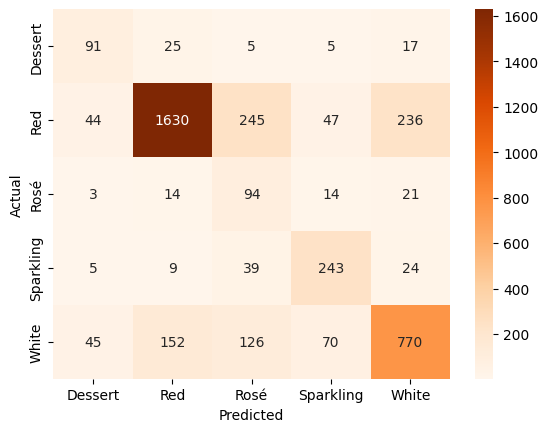

In [48]:
# Performance on the test set
score_model(clf, X_test_encoded_rf, y_test)

In [49]:
# Model improvement and AUC scores
rf_base, rf_best = calculate_AUC_scores(rf, clf, X_test_encoded_rf, y_test)

The AUC of the base model is: 0.87
The AUC of the best model is: 0.91
The improvement in performance is: 4.6%


### MLPClassifier

              precision    recall  f1-score   support

     Dessert       0.88      0.49      0.63       143
         Red       0.83      0.90      0.86      2202
        Rosé       0.34      0.18      0.24       146
   Sparkling       0.76      0.72      0.74       320
       White       0.73      0.72      0.72      1163

    accuracy                           0.79      3974
   macro avg       0.71      0.60      0.64      3974
weighted avg       0.78      0.79      0.78      3974



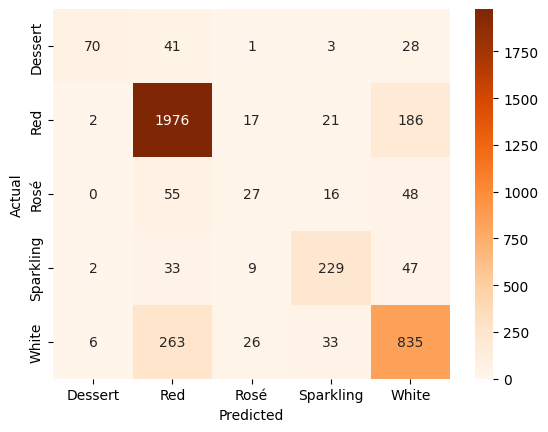

In [50]:
# Performance on the test set
score_model(clf1, X_test_encoded_nn, y_test)

In [51]:
# Model improvement and AUC scores
nn_base, nn_best = calculate_AUC_scores(nn, clf1, X_test_encoded_nn, y_test)

The AUC of the base model is: 0.87
The AUC of the best model is: 0.9
The improvement in performance is: 3.45%


### XGBClassifier

              precision    recall  f1-score   support

     Dessert       0.85      0.54      0.66       143
         Red       0.82      0.91      0.86      2202
        Rosé       0.46      0.16      0.24       146
   Sparkling       0.81      0.72      0.76       320
       White       0.74      0.70      0.72      1163

    accuracy                           0.79      3974
   macro avg       0.74      0.61      0.65      3974
weighted avg       0.78      0.79      0.78      3974



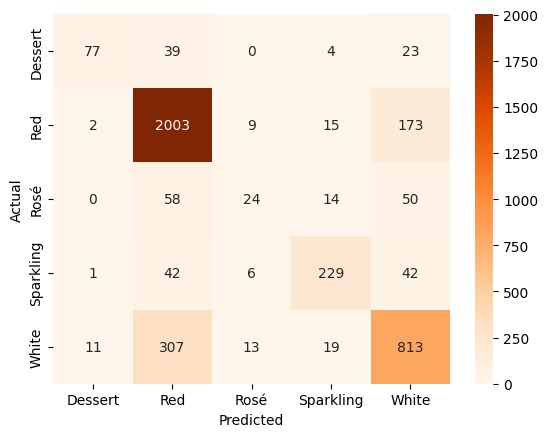

In [52]:
# Performance on test set
score_model(clf2, X_test_encoded_xgb, y_test)

In [53]:
# Model improvement and AUC scores
xgb_base, xgb_best = calculate_AUC_scores(xgb, clf2, X_test_encoded_xgb, y_test)

The AUC of the base model is: 0.9
The AUC of the best model is: 0.9
The improvement in performance is: 0.0%


## Model Interpretation

### Random Forest

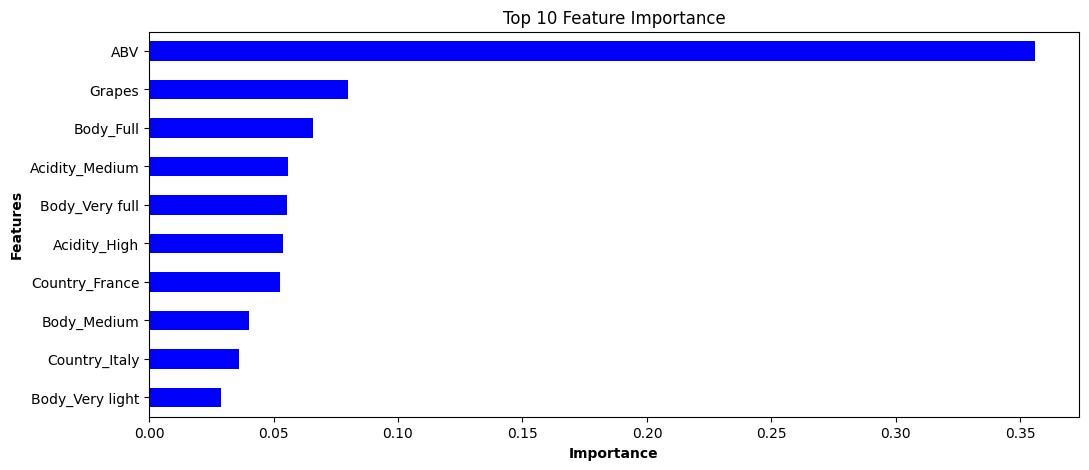

In [54]:
# helper function to get feature importance    
def plot_importance(model, X):

    importances = pd.Series(data=model.feature_importances_,
                            index= list(X.columns))
    
    importances_sorted = importances.sort_values()
    
    importances_sorted = importances_sorted[-10:]

    plt.figure(figsize = (12, 5))
    importances_sorted.plot(kind='barh', color='blue')
    plt.title('Top 10 Feature Importance')
    plt.xlabel("Importance", fontweight = 'bold')
    plt.ylabel("Features", fontweight = 'bold')
    plt.show()

plot_importance(rf_gs.best_estimator_.named_steps["random_forest"], X_train_encoded_rf)

### MLPClassifier

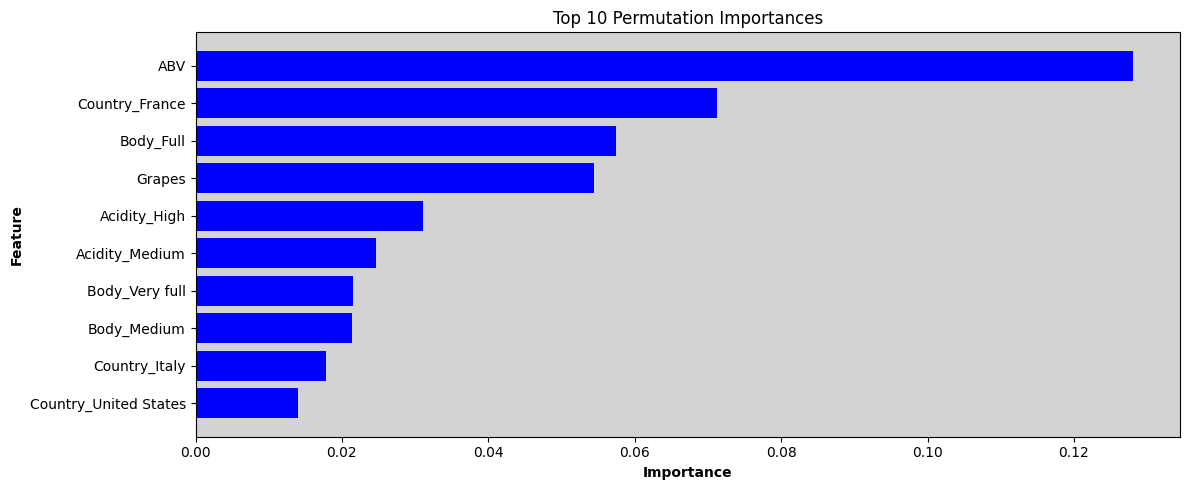

In [55]:
# plot feature importance
result = permutation_importance(clf, X_test_encoded_nn, y_test, n_repeats = 10, random_state = 100)

# Plot the feature importances
fig, ax = plt.subplots(figsize=(12, 5))
sorted_idx = result.importances_mean.argsort()[-10:]
ax.barh(X_test_encoded_nn.columns[sorted_idx], result.importances_mean[sorted_idx], color='blue')
ax.set_title("Top 10 Permutation Importances")
ax.set_facecolor('lightgrey')
ax.set_xlabel('Importance', fontweight = 'bold')
ax.set_ylabel('Feature', fontweight = 'bold')
ax.set_yticklabels(X_test_encoded_nn.columns[sorted_idx], fontsize=10)
fig.tight_layout()
plt.show()

### XGBClassifier

In [56]:
# fig, ax = plt.subplots(figsize=(10, 6))
# plot_importance(clf2, max_num_features=10, ax=ax)
# plt.show()

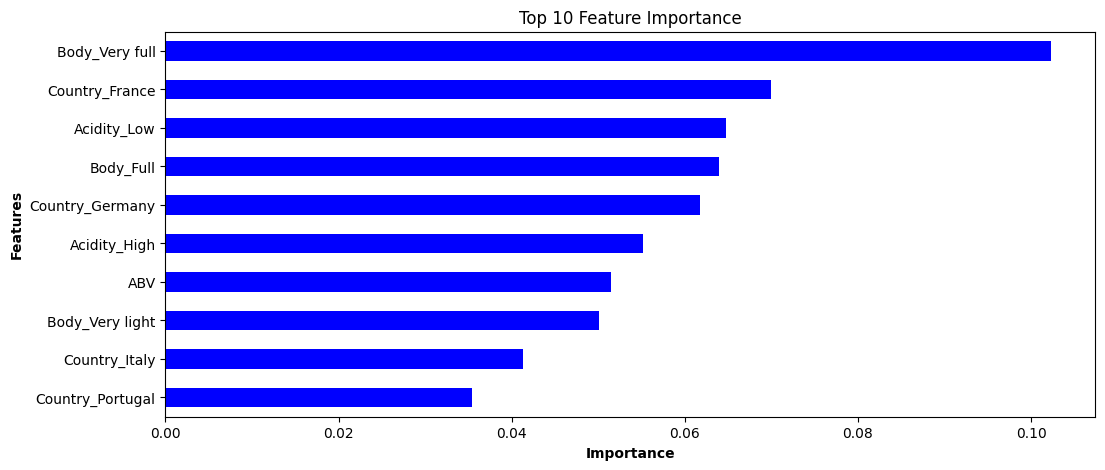

In [57]:
plot_importance(xgb_gs.best_estimator_.named_steps['xgb'], X_train_encoded_xgb)

## Model Comparison

In [58]:
# creating a dataframe to compare models
classifier = ['Random Forest', 'Multi-Layer Percepton', 'XGBoost']
scores = [rf_best, nn_best, xgb_best]

comparison = pd.DataFrame({'Model': classifier,
                           'AUC': scores})

comparison = comparison.sort_values(by='AUC', ascending = False).reset_index(drop=True)

comparison

,Model,AUC
0,Random Forest,0.91
1,Multi-Layer Percepton,0.90
2,XGBoost,0.90


## Recommender Function

### Getting User Inputs

In [59]:
# define a function to get user inputs for recommendation

def get_inputs():

    body_options = ['Full', 'Light', 'Medium', 'Very full', 'Very light']
    acidity_options = ['High', 'Low', 'Medium']
    country_options = ['Argentina', 'Australia', 'Austria', 'Brazil', 'Bulgaria', 'Canada', 'Chile', 'Croatia', 'Czech Republic', 'France', 'Georgia', 'Germany', 'Greece', 'Hungary', 'Israel', 'Italy', 'Mexico', 'Moldova', 'New Zealand', 'Portugal', 'Romania', 'Russia', 'South Africa', 'Spain', 'Switzerland', 'United States', 'Uruguay']
    harmonize_options = ['White Meat', 'Red Meat', 'Game Meat', 'Vegetarian', 'Spicy Food', 'Seafood', 'Dessert', 'Cheese', 'Cured Meat', 'Snacks', 'Appetizer', 'Italian', 'Others']

    while True:
        body = input(f'Enter the body of the wine you want. You have the following choices: {", ".join(body_options)}.')
        body = body.title()
        if body in body_options:
            break

    while True:
        acidity = input(f'Enter the acidity level of the wine you want. You have the following choices: {", ".join(acidity_options)}.')
        acidity = acidity.title()
        if acidity in acidity_options:
            break

    while True:
        country = input(f'Enter the country you want your wine from. You have the following choices: {", ".join(country_options)}.')
        country = country.title()
        if country in country_options:
            break

    while True:
        try:
            grapes = int(input('Enter the number of grapes you want in your wine. More grapes means the taste of the wine may be more complex.'))
            break
        except ValueError:
            pass

    while True:
        try:
            abv = float(input('Enter the desired alcohol percentage of your wine.'))
            break
        except ValueError:
            pass

    while True:
        harmonize = input(f'Enter the type of food(s) you want your wine to pair with. You have the following choices: {", ".join(harmonize_options)}.')
        harmonize = harmonize.title()
        if harmonize.title() in harmonize_options:
            break

    body = 'Body_' + body
    acidity = 'Acidity_' + acidity 
    country = 'Country_' + country
    harmonize = 'Harmonize_' + harmonize

    return body, acidity, country, grapes, abv, harmonize


### Using Model to predict the type of wine

In [61]:
body, acidity, country, grapes, abv, harmonize = get_inputs()

input_dict = {body: 1, 
              acidity: 1, 
              country: 1,
              'ABV': abv,
              'Grapes': grapes,
              harmonize: 1}

# Convert the input dictionary to a pandas DataFrame
input_data = pd.DataFrame.from_dict(input_dict, orient='index').T

In [66]:
# Get the columns from training_data
columns = X_train_encoded_rf.columns

# Reindex input_data with the columns from training_data
input_data = input_data.reindex(columns, axis=1)

# Fill in the missing columns with a value of 0
input_data = input_data.fillna(0)

In [93]:
# Generating prediction
predict = clf.predict(input_data)[0]
predict

'White'

In [105]:
# importing ratings dataset
ratings = pd.read_csv('XWines_800K_ratings.csv')
ratings = ratings[['WineID', 'Rating']]

In [106]:
# calculating average ratings
avg_ratings = ratings.groupby('WineID')['Rating'].mean().to_frame('Avg_Ratings').reset_index()
avg_ratings['Avg_Ratings'] = avg_ratings['Avg_Ratings'].round(2)

In [107]:
# merging catalogue with ratings
combined = pd.merge(catalogue, avg_ratings, how = 'inner', on = 'WineID')

In [110]:
filtered = combined[combined['Type'] == predict].sort_values(by = 'Avg_Ratings', ascending = False).reset_index(drop = True)

In [118]:
std_abv = filtered['ABV'].std()

upper_bound = abv + std_abv * 0.5
lower_bound = abv - std_abv * 0.5

In [119]:
recommendations = filtered[filtered['ABV'].between(lower_bound, upper_bound, inclusive = 'both')].head()
recommendations

,WineID,WineName,Type,Elaborate,Grapes,Harmonize,ABV,Body,Acidity,Code,Country,RegionID,RegionName,WineryID,WineryName,Website,Vintages,Avg_Ratings
26,199356,Traminer,White,Varietal/100%,1,"Cured Meat, Italian, Seafood, Cheese",11.5,Medium,High,MD,Moldova,2449,Moldova Viniculture,68582,Mileştii Mici,http://www.milestii-mici.md,"2020, 2019, 2018, 2017, 2016, 2015, 2014, 2012...",5.0
27,176843,Riesling,White,Varietal/100%,1,"Seafood, Snacks, White Meat, Red Meat, Cured M...",11.5,Light,High,AU,Australia,2105,Clare Valley,62824,Bird In Hand,http://www.birdinhand.com.au,"2021, 2020, 2019, 2018, 2017, 2016, 2015, 2014...",5.0
95,104683,Alias Branco de Outrora,White,Varietal/100%,1,"Cured Meat, Seafood, Others, Snacks",11.0,Light,High,PT,Portugal,1046,Bairrada,12652,Outrora,NaN,"2020, 2019, 2018, 2017, 2016, 2015, 2014, 2013...",5.0
165,192538,Riesling,White,Varietal/100%,1,"Seafood, White Meat, Red Meat, Spicy Food, Cur...",11.5,Light,High,CA,Canada,2208,Okanagan Valley,65927,Cedar Creek Estate Winery,http://www.cedarcreek.bc.ca,"2020, 2019, 2018, 2017, 2016, 2015, 2014, 2013...",5.0
186,160010,Moscatel-Gewürztraminer,White,Assemblage/Blend,2,"Seafood, Dessert, White Meat, Spicy Food, Cheese",11.5,Light,Low,ES,Spain,2037,Vino de España,38847,Bahia Alta,NaN,"2021, 2020, 2019, 2018, 2017, 2016, 2011, 2001...",5.0
